This is an example notebook to demonstrate the prediction of temperature time-series data using the generalized Langevin equation (GLE) on the example of a loaded Berlin weather trajectory.

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from mempred import *

import datetime as dt

from wwo_hist import retrieve_hist_data

%matplotlib inline

## Loading weather data (here with OpenWeatherMap)

In [2]:
#frequency in hours!
#add your api key from OpenWeatherMap
#be careful! you only have 500 free calls each day!

#the DataFrame will be saved in the same folder

#key = 'f51f39fe055c46e09c8123240201002'
#data = load_temp("berlin", key = key, start_date = "10-FEB-2009", end_date = "07-MAR-2020", frequency = 24)

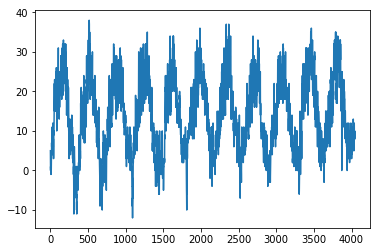

In [3]:
data = pd.read_csv('berlin.csv')
data.head()
data['maxtempC'].plot()

## Memory Kernel Extraction (with fit)

fitted memory time: 0.26 time units
fitted osc. time: 164.15 time units
plotting extracted memory kernel...


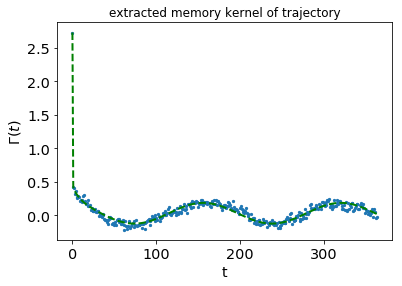

plotting running integral of kernel...


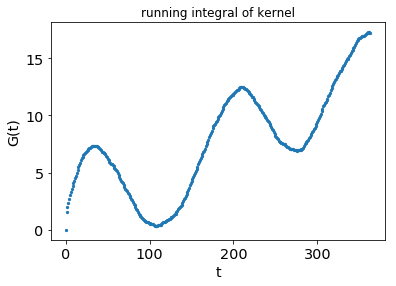

In [4]:
#data.index = pd.to_numeric(data.index, errors='coerce').fillna(0).astype(int)
#data["maxtempC"] = pd.to_numeric(data["maxtempC"], errors='coerce').fillna(0).astype(int)

cut = len(data)-300
n_steps = 100
trunc = 365
p0 = (1,1,1,167,0,0)
predict=GLEPredictionMETEO(bins=10,  cut = cut ,trunc=trunc, dt = 1, no_fe=False, plot_pred = True)
kernel = predict.extractKernel([data["maxtempC"].values], fit_kernel = True, fit_start = 1, plot_kernel = True,p0 = p0)

## Performing prediction by extracting memory kernel and simulate GLE

plotting prediction...


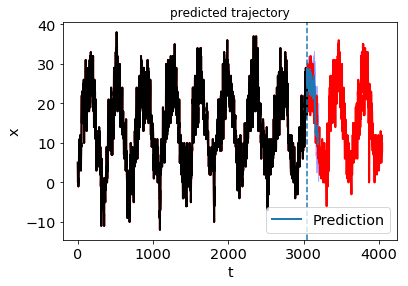

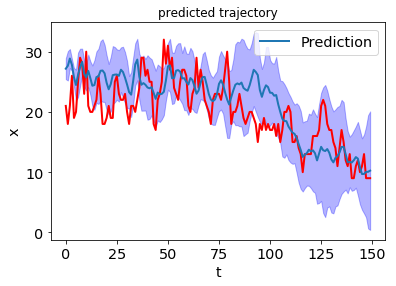

In [16]:
#important to convert all strings to floats!! In future version, this will already be in loaddata.py

#data.index = pd.to_numeric(data.index, errors='coerce').fillna(0).astype(int)
#data["maxtempC"] = pd.to_numeric(data["maxtempC"], errors='coerce').fillna(0).astype(int)

cut = len(data)-1000
n_steps = 150
trunc = 167
predict=GLEPredictionMETEO(bins=10,  cut = cut ,trunc=trunc, dt = 1, no_fe=False, plot_pred = True)
kernel = predict.extractKernel([data["maxtempC"].values])

GLE=predict.predictGLE([data["maxtempC"].values], n_steps=n_steps, n_preds = 10, return_full_trjs=True, zero_noise = False, alpha = 1,cond_noise = 10)

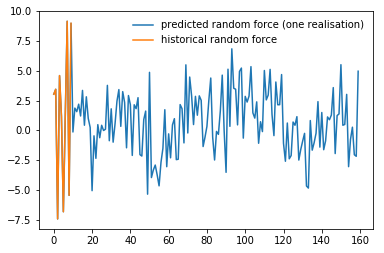

In [17]:
fr_trj = GLE[-1]
plt.plot(fr_trj[cut-10:],label='predicted random force (one realisation)')
plt.plot(fr_trj[cut-10:cut],label='historical random force')
plt.legend(loc='best',frameon=False)

## Also here, a hyper parameter optimization using mpGridSearch can be performed!

optimal alpha : 1
optimal trunc : 190
optimal conditional time : None


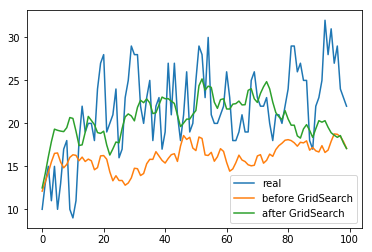

In [6]:
truncs = np.arange(150,200,5)
alphas = np.arange(1,10,2)
ts = [None]
n_steps = 100

cut = 3000


best_error, pred_GLE_best, best_trunc, best_alpha,best_th = mp_grid_search(data, value = 'maxtempC', cut = cut, n_steps = n_steps, truncs = truncs, alphas = alphas,ts = ts)

mem = GLEPredictionMETEO(cut = cut, dt = 1, trunc = best_trunc, plot_pred = False, no_fe = True)

kernel = mem.extractKernel([data["maxtempC"].values])
pred_GLE_best=mem.predictGLE([data["maxtempC"].values], n_steps = n_steps, n_preds = 10, return_full_trjs=True, zero_noise = False, alpha = best_alpha,cond_noise = best_th)

mem = GLEPredictionMETEO(cut = cut, dt = 1, trunc = 100, plot_pred = False, no_fe = True)

kernel = mem.extractKernel([data["maxtempC"].values])
predGLE_default=mem.predictGLE([data["maxtempC"].values], n_steps = n_steps, n_preds = 10, return_full_trjs=True, zero_noise = False, alpha = 1,cond_noise = 1)

plt.plot(data["maxtempC"][cut:cut+n_steps].values, label = 'real')
plt.plot(predGLE_default[2], label = 'before GridSearch')
plt.plot(pred_GLE_best[2], label = 'after GridSearch')
plt.legend(loc = 'best')